In [11]:
import os

import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

from matplotlib import colors
from reaches import readNHD
from reaches import segmentReach
from reaches import bitwiseMask
from reaches import makeGDF

In [2]:
# Order of all possible bins for plotting
order = ['(0, 10]', '(10, 20]', '(20, 30]', '(30, 40]', '(40, 50]',
         '(50, 60]', '(60, 70]', '(70, 80]', '(80, 90]', '(90, 100]',
         '(100, 150]', '(150, 200]', '(200, 500]', '(500, 1000]']

#### Original PIXC granule

In [3]:
data_path = '/nas/cee-water/cjgleason/fiona/data/small_rivers/mar_2024_ver_c/'
pixc_path = os.path.join(data_path, 'SWOT_L2_HR_PIXC_012_298_080L_20240317T084237_20240317T084248_PIC0_01.nc')
tile_name = pixc_path[-71:-3]

# Read in xarray
ds_PIXC = xr.open_mfdataset(paths=pixc_path, group = 'pixel_cloud', engine='h5netcdf')

In [12]:
# Make mask
mask = bitwiseMask(ds_PIXC)

(887993,)


In [13]:
variables = ['azimuth_index', 'range_index', 'cross_track',
             'pixel_area', 'height', 'geoid',
             'dlatitude_dphase', 'dlongitude_dphase',
             'dheight_dphase', 'classification']

In [14]:
# If dataframe not empty after filtering
if mask.shape != (0,):
    # Make PIXC
    gdf_PIXC = makeGDF(ds=ds_PIXC, mask=mask, data_vars=variables)
    # # Append to list
    # d.append(gdf_PIXC)

In [4]:
# Make dict for legend labels
flags = ds_PIXC.classification.flag_meanings.split() # extract each flag meaning
codes = {idx:k for idx, k in enumerate(flags, start=1)}

#### Read in pseudo-pixels

In [5]:
data_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/PIXC_v2_0_pseudo_pixels_filtered/'

In [6]:
pseudo_path = os.path.join(data_path,
                           'SWOT_L2_HR_PIXC_012_298_080L_20240317T084237_20240317T084248_PIC0_01.parquet')

In [7]:
gdf_PIXC = gpd.read_parquet(pseudo_path)

In [8]:
pseudo = gdf_PIXC.drop(columns='geometry').set_geometry('pseudo_pixel').set_crs(crs=gdf_PIXC.crs)

#### Read in NHD

In [6]:
index = 4 # Connecticut River

In [8]:
# Read prepped NHD
basin, huc4, huc2 = readNHD(index=index)

In [10]:
basin['buffer'] = basin.buffer(distance=((basin.WidthM/2)+50), cap_style='flat')

In [26]:
# Project crs
basin = basin.to_crs(epsg=32618)

In [17]:
# # Get bounds of pseudo-pixels
# pbounds = gdf_PIXC.total_bounds
#  NEEDS TO BE BIGGER BUFFERED TO CAPTURE PSEUDO PIXELS

In [20]:
# # Crop NHD to current tile
# basin_crop = basin.clip(pbounds)

In [24]:
basin = basin.set_geometry('buffer')

In [29]:
# Get pixels in buffered reaches
inside = gpd.sjoin(gdf_PIXC, basin, how='inner',
                       predicate='within')

In [30]:
inside

,points,azimuth_index,range_index,cross_track,pixel_area,height,geoid,dlatitude_dphase,dlongitude_dphase,dheight_dphase,...,latitude,longitude,geometry,index_right,Bin,GNIS_Name,LengthKM,NHDPlusID,WidthM,geometry_right
4,496,160.0,1257.0,-20060.488281,641.220032,236.046875,-28.926233,-0.000255,-0.001408,-3.020458,...,42.696443,-72.770210,POINT (682642.42 4729516.869),21952,"(10, 20]",West Branch North River,1.448,1.000090e+13,16.045485,"LINESTRING (682571.291 4729624.41, 682578.416 ..."
7,535,160.0,1296.0,-20994.736328,612.744873,207.906326,-28.925648,-0.000256,-0.001408,-3.027173,...,42.696540,-72.769683,POINT (682685.298 4729528.757),21952,"(10, 20]",West Branch North River,1.448,1.000090e+13,16.045485,"LINESTRING (682571.291 4729624.41, 682578.416 ..."
8,536,160.0,1297.0,-21007.921875,612.361267,207.830246,-28.925303,-0.000255,-0.001408,-3.031179,...,42.696597,-72.769369,POINT (682710.888 4729535.799),21952,"(10, 20]",West Branch North River,1.448,1.000090e+13,16.045485,"LINESTRING (682571.291 4729624.41, 682578.416 ..."
9,537,160.0,1298.0,-21018.623047,612.050476,207.248871,-28.925215,-0.000255,-0.001408,-3.032200,...,42.696612,-72.769289,POINT (682717.4 4729537.62),21952,"(10, 20]",West Branch North River,1.448,1.000090e+13,16.045485,"LINESTRING (682571.291 4729624.41, 682578.416 ..."
10,538,160.0,1299.0,-21053.603516,611.035400,206.932098,-28.924994,-0.000255,-0.001408,-3.034759,...,42.696649,-72.769088,POINT (682733.754 4729542.104),21952,"(10, 20]",West Branch North River,1.448,1.000090e+13,16.045485,"LINESTRING (682571.291 4729624.41, 682578.416 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887919,6423514,3105.0,2850.0,-47989.863281,268.562531,184.801208,-29.223537,-0.000248,-0.001401,-7.403436,...,42.197723,-72.244410,POINT (727512.285 4675405.872),14597,"(0, 10]",None,0.398,1.000090e+13,2.379599,"LINESTRING (727525.052 4675407.222, 727481.521..."
887920,6423515,3105.0,2851.0,-48009.968750,268.450317,184.372330,-29.223452,-0.000248,-0.001401,-7.404207,...,42.197734,-72.244350,POINT (727517.196 4675407.213),14597,"(0, 10]",None,0.398,1.000090e+13,2.379599,"LINESTRING (727525.052 4675407.222, 727481.521..."
887925,6423520,3105.0,2856.0,-48119.949219,267.838074,185.318527,-29.222191,-0.000248,-0.001401,-7.415616,...,42.197891,-72.243463,POINT (727589.855 4675427.058),59569,"(0, 10]",None,0.279,1.000090e+13,1.512897,"LINESTRING (727786.917 4675615.985, 727784.508..."
887926,6423522,3105.0,2858.0,-48171.656250,267.551086,186.285782,-29.221533,-0.000248,-0.001401,-7.421613,...,42.197974,-72.242997,POINT (727628.056 4675437.483),59569,"(0, 10]",None,0.279,1.000090e+13,1.512897,"LINESTRING (727786.917 4675615.985, 727784.508..."


In [14]:
# basin.crs

In [14]:
# bounds_PIXC = pseudo.union_all().convex_hull # HANGS FOREVER

In [15]:
# Drop all geometries that aren't LineStrings
# (If a river flows across the PIXC boundary then back in, becomes
# MultiLineString and needs to be dropped for now).
basin_crop = basin_crop[basin_crop.geometry.geometry.type=='LineString']

#### Let's try

In [43]:
def getCoverage(reach, basin_crs, pseudo, percent):

    # Check that this reach and the pseudo-pixels are in the same crs
    assert basin_crs == pseudo.crs

    ## Get the bounds of the full, buffered reach for clipping the pseudo-pixels
    # Buffer the reach by 1/2 width on each side
    reach_buff = reach.geometry.buffer(distance=(reach.WidthM/2), cap_style='flat')
    # Get the bounds of the full, buffered reach
    bounds = reach_buff.bounds
    # bounds = list(bounds.itertuples(index=False, name=None))[0]

    ## Clip the pseudo pixels to the bounds of the reach
    clipped = pseudo.clip(bounds) ###
    clipped_all = clipped.union_all()

    # Segment the reach and buffer the segments
    # Segment the reach (returns list of linestrings
    segments = segmentReach(reach)
    # Buffer segments
    segments = gpd.GeoSeries(segments).buffer(distance=(reach.WidthM/2), cap_style='flat')
    
    # # Create a GeoDataFrame of segments
    # segments = gpd.GeoDataFrame(segments).rename(columns={0: 'geometry'}).set_geometry('geometry').set_crs(basin_crs)
    # # Buffer the segments
    # segments['seg_buffer'] = segments.buffer(distance=(reach.WidthM/2), cap_style='flat')
    # # Set the active geometry column to the buffered segments
    # segments = segments.set_geometry('seg_buffer')
    
    ## Calculate the coverage
    # segments['coverage'] = segments.apply(func=calcCov, args=(clipped_all), axis=1)
    coverage = []
    
    for i in range(len(segments)):
        prop = clipped_all.intersection(segments[i]).area/segments[i].area
        coverage.append(prop)
    # if inside.empty:
    #     prop = 0
    # else:    

#     # Get number of pixels in each reach segment
#     counts = pd.DataFrame(inside.segment.value_counts().reset_index().sort_index())

    # Calculate coverage (proportion of reaches with >= 1 pixel in them)
    # prop = len(reach.loc[reach['coverage'] >= percent])/10
    final_prop = sum(i > percent for i in coverage)/10

    return final_prop

In [44]:
# test = basin.iloc[64495:64500]
test = basin.groupby('Bin').sample(1)

In [45]:
## Analyze coverage
# Set number of pixels per segment needed for detection
percent = 0.5

# Get the coverage for each reach (at least one pixel/segment)
test['coverage'] = test.apply(func=getCoverage,
                                          args=(basin.crs, pseudo, percent),
                                          axis=1)

In [52]:
# test

In [53]:
## Analyze coverage
# Set number of pixels per segment needed for detection
percent = 0.5

# Get the coverage for each reach (at least one pixel/segment)
basin_crop['coverage'] = basin_crop.apply(func=getCoverage,
                                          args=(basin.crs, pseudo, percent),
                                          axis=1)

In [42]:
basin_crop[basin_crop['coverage'] != 0]

,Bin,GNIS_Name,LengthKM,NHDPlusID,WidthM,geometry,coverage
18396,"(10, 20]",Manhan River,1.287000,1.000090e+13,17.122821,"LINESTRING (685916.356 4674686.767, 685909.534...",0.5
3395,"(10, 20]",Manhan River,0.810000,1.000090e+13,17.194588,"LINESTRING (686321.821 4675175.658, 686321.94 ...",0.1
28899,"(0, 10]",None,0.451000,1.000090e+13,1.623840,"LINESTRING (686946.737 4677515.739, 686970.178...",0.1
30330,"(10, 20]",Sodom Brook,1.836000,1.000090e+13,10.077749,"LINESTRING (684023.353 4685460.002, 684035.541...",0.1
10928,"(0, 10]",Potash Brook,0.152000,1.000090e+13,3.265634,"LINESTRING (687369.351 4678263.512, 687359.502...",0.1
...,...,...,...,...,...,...,...
48851,"(20, 30]",Green River,0.334000,1.000090e+13,21.247479,"LINESTRING (690831.008 4731915.22, 690831.162 ...",0.2
29225,"(0, 10]",None,0.379000,1.000090e+13,3.640280,"LINESTRING (689065.271 4730080.6, 689066.862 4...",0.4
22392,"(20, 30]",East Branch North River,1.188954,1.000090e+13,22.592855,"LINESTRING (688506.336 4730694.625, 688508.993...",1.0
49159,"(0, 10]",None,1.092000,1.000090e+13,2.466686,"LINESTRING (690081.263 4732270.253, 690102.018...",0.1


In [ ]:
# Find width bins present in cropped hydrography
bins = list(np.unique(basin_crop.Bin))
bins

In [ ]:
# Make sorted list of bins present
ordered = []
for binn in order:
    if binn in bins:
        ordered.append(binn)
ordered

In [39]:
mean_cov = basin_crop.groupby('Bin')['coverage'].mean()

In [ ]:
print(mean_cov)

In [ ]:
# plt.scatter(x=ordered, y=coverage, c='k')
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(x=mean_cov.keys(), y=mean_cov.values, c='k')
plt.title('Mean percent of reach detected in ' + huc4 +' by \n'
          + tile_name)
plt.xticks(rotation=-45);

# Set number of ticks for x-axis
ax.set_xticks(range(len(ordered)))
# Set ticks labels for x-axis
ax.set_xticklabels(ordered)

plt.xlabel('Bankfull Width (m)')
plt.ylabel('Percent Detected')
# plt.savefig(fname='./figures_for_unit_test/one_tile_'+ huc4 +'.png', bbox_inches='tight')

#### Sanity check

In [47]:
palette = {3: 'cornflowerblue', 4: 'blue', 5: 'hotpink',
           6: 'darkkhaki', 7: 'springgreen'} # 6: 'lightsalmon', 7: 'lightblue'

In [46]:
# Extract just one buffered reach
conn = basin[basin['NHDPlusID'] == 10000900065602]
# conn = basin[basin['NHDPlusID'] == 10000900041465]

In [48]:
conn_buf = conn.copy()

In [49]:
conn_buf['reach_buffer'] = conn_buf.buffer(distance=(conn_buf.WidthM/2),cap_style='flat')

In [50]:
conn_buf = conn_buf.set_geometry('reach_buffer')

In [51]:
bounds = conn_buf.bounds
bounds = list(bounds.itertuples(index=False, name=None))[0]

In [52]:
clipped = pseudo.clip(bounds)
clipped_all = clipped.union_all()

In [53]:
# Segment the reach
conn.loc[:,'segments'] = conn.apply(func=segmentReach, axis=1) 

/work/pi_cjgleason_umass_edu/.conda/envs/narrowPIXC/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [54]:
# Check that this reach and the pseudo-pixels are in the same crs
assert conn.crs == pseudo.crs

In [55]:
# conn = conn.drop(columns='geometry').explode(column='segments').set_geometry('segments')
conn = conn.explode(column='segments').set_geometry('segments')

In [56]:
# Make GeoSeries with just segments
segments = gpd.GeoSeries(data=conn['segments'], crs=conn.crs)

In [58]:
# Buffer segments by 1/2 the calculated width
# CITE BEIGER
segments = segments.buffer(distance=(conn.WidthM/2),cap_style='flat')

In [59]:
conn['reach_buffer'] = conn.buffer(distance=(conn.WidthM/2),cap_style='flat')

In [60]:
conn = conn.set_geometry('reach_buffer')

<Axes: >

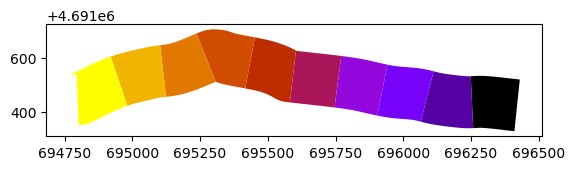

In [61]:
conn.plot(cmap='gnuplot')

In [62]:
coverage = {}

for i in range(len(conn)):
    coverage[i] = clipped_all.intersection(segments.iloc[i]).area/segments.iloc[i].area

In [63]:
coverage

{0: 0.6182082577274667,
 1: 0.628807257615828,
 2: 0.6648718636442351,
 3: 0.7401895806316029,
 4: 0.6855842540914756,
 5: 0.6757409636124224,
 6: 0.7426461021086365,
 7: 0.7553141150377743,
 8: 0.7805047621168238,
 9: 0.7766039669974796}

(4691328.118653536, 4691704.007606101)

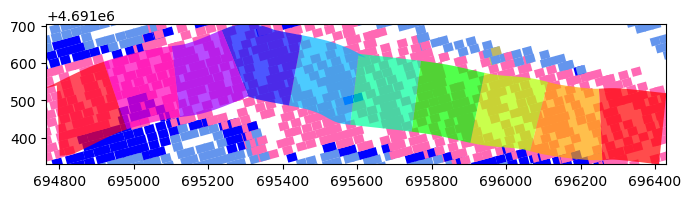

In [65]:
nums = list(np.unique(clipped.klass).astype('int'))
labels = [codes[x] for x in nums]

# Make cmap
cmap = colors.ListedColormap([palette[x] for x in nums])

fig, ax = plt.subplots(figsize=(8,8))

clipped.plot(ax=ax, column='klass',
             cmap=cmap)
conn.plot(ax=ax, cmap='hsv', alpha=0.7)

plt.xlim(bounds[0], bounds[2])
plt.ylim(bounds[1], bounds[3])